# Regridding AGCD

This file pertains to regridding agcd from the NCI with climtas

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import climtas
import cartopy.crs as ccrs
import dask
dask.config.set({"array.slicing.split_large_chunks": True})

from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
AWAP_DIR = '/g/data/w40/ab2313/mjo_and_rainfall_trend'
UNREGRID_DIR = '/g/data/zv2/agcd/v1/precip/calib/r005/01day'

This is the targed grid

In [60]:
# This is the original file sent by Andrew
awap_target = xr.open_dataset(os.path.join(AWAP_DIR, 'precip_calib_0.25_1911_2017_land.nc'))
# Lat x lon subset of NWA australia region + extra for context
awap_target = awap_target.sel(lat=slice(-30, -5), lon=slice(100, 155))
awap_target

<xarray.Dataset>
Dimensions:  (lon: 178, lat: 139, time: 39082)
Coordinates:
  * lon      (lon) float64 112.0 112.2 112.5 112.8 ... 155.5 155.8 156.0 156.2
  * lat      (lat) float64 -44.5 -44.25 -44.0 -43.75 ... -10.5 -10.25 -10.0
  * time     (time) datetime64[ns] 1911-01-01T09:00:00 ... 2017-12-31T09:00:00
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.2 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Fri Dec 07 18:54:17 2018: cdo ifthen grid_0.25.nc precip_ca...
    CDO:          Climate Data Operators version 1.6.2 (http://code.zmaw.de/p...

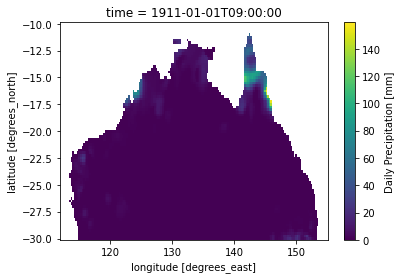

In [65]:
awap_target.isel(time=0).precip.plot()

These are the files that need to be regridded.

In [66]:
np.array(os.listdir(UNREGRID_DIR))[:5]

array(['agcd_v1_precip_calib_r005_daily_2003.nc',
       'agcd_v1_precip_calib_r005_daily_1948.nc',
       'agcd_v1_precip_calib_r005_daily_1940.nc',
       'agcd_v1_precip_calib_r005_daily_1911.nc',
       'agcd_v1_precip_calib_r005_daily_1921.nc'], dtype='<U39')

# Test

In [67]:
test_file = xr.open_dataset(f'{UNREGRID_DIR}/agcd_v1_precip_calib_r005_daily_2003.nc')
test_file = test_file.isel(nv = 0).squeeze().precip
test_file

<xarray.DataArray 'precip' (time: 365, lat: 691, lon: 886)>
[223462490 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-12-31T09:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:                  time: sum
    units:                         mm
    analysis_version_number:       3.01
    long_name:                     Daily precipitation
    number_of_stations_reporting:  6786
    standard_name:                 lwe_thickness_of_precipitation_amount
    frequency:                     daily
    length_scale_for_analysis:     80.0
    grid_mapping:                  crs
    coverage_content_type:         physicalMeasurement
    valid_range:                   [     0. 100000.]

In [68]:
agcd_regridder = climtas.regrid.Regridder(test_file, awap_target)
agcd_regridder

In [69]:
regrid_test = agcd_regridder.regrid(test_file)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/climtas/regrid.py:380: UserWarning: rename 'i' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  target_da = target_da.rename({"i": "lat", "j": "lon"})
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/climtas/regrid.py:380: UserWarning: rename 'j' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  target_da = target_da.rename({"i": "lat", "j": "lon"})
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/climtas/regrid.py:389: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  target_da = target_da.rename({"lat": source_lat.name, "lon": source_lon.name})
/g/data/

In [70]:
regrid_test

<xarray.DataArray 'precip' (time: 365, lat: 81, lon: 173)>
dask.array<reshape, shape=(365, 81, 173), dtype=float64, chunksize=(365, 81, 173), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-12-31T09:00:00
    lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
    lon      (lon) float64 112.0 112.3 112.5 112.8 ... 154.3 154.5 154.7 155.0

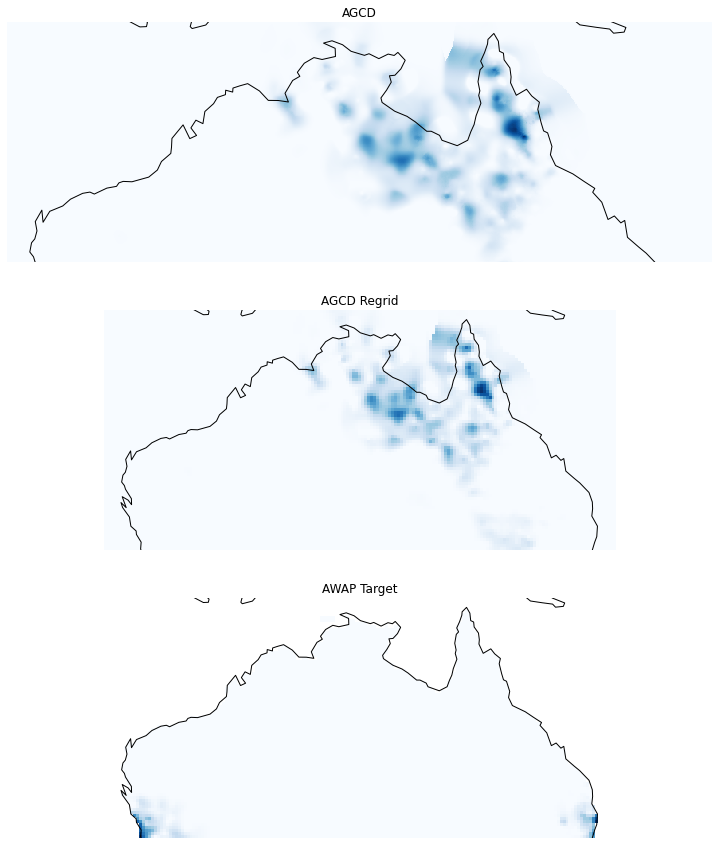

In [71]:
fig = plt.figure(figsize = (15,15))
gs = gridspec.GridSpec(3,1)

ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
test_file.sel(lat = slice(-25,-10), lon = slice(112,156.2))\
            .isel(time = 0).plot(ax = ax1, add_colorbar = False, cmap = 'Blues')
ax1.coastlines(resolution = '110m')
ax1.spines['geo'].set_visible(False)
ax1.set_title('AGCD')

ax2 = fig.add_subplot(gs[1], projection = ccrs.PlateCarree())
regrid_test.isel(time = 0).plot(ax = ax2, add_colorbar = False, cmap = 'Blues')
ax2.coastlines(resolution = '110m')
ax2.spines['geo'].set_visible(False)
ax2.set_title('AGCD Regrid')



ax3 = fig.add_subplot(gs[2], projection = ccrs.PlateCarree())
awap_target.precip.isel(time = 205).plot(ax = ax3, add_colorbar = False, cmap = 'Blues')
ax3.coastlines(resolution = '110m')
ax3.spines['geo'].set_visible(False)
ax3.set_title('AWAP Target');

# Test with Weights

Regridding using weights - rainfall must be regridded with conservative regridding.

In [72]:
# weights = climtas.regrid.cdo_generate_weights(TXx_ds.Ann, gistemp_ds.air, method='bil?)
# TXx_Ann_regrid = climtas.regrid.Regridder(weights=weights).regrid(TXx_ds.Ann)

In [73]:
weights = climtas.regrid.cdo_generate_weights(test_file, awap_target, method = 'con')

In [74]:
type(weights)

xarray.core.dataset.Dataset

In [75]:
weights

<xarray.Dataset>
Dimensions:              (src_grid_rank: 2, dst_grid_rank: 2,
                          src_grid_size: 612226, dst_grid_size: 14013,
                          num_links: 347789, num_wgts: 1)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, src_grid_size,
                                dst_grid_size, num_links, num_wgts
Data variables: (12/15)
    src_grid_dims        (src_grid_rank) int32 ...
    dst_grid_dims        (dst_grid_rank) int32 ...
    src_grid_center_lat  (src_grid_size) float64 ...
    dst_grid_center_lat  (dst_grid_size) float64 ...
    src_grid_center_lon  (src_grid_size) float64 ...
    dst_grid_center_lon  (dst_grid_size) float64 ...
    ...                   ...
    dst_grid_area        (dst_grid_size) float64 ...
    src_grid_frac        (src_grid_size) float64 ...
    dst_grid_frac        (dst_grid_size) float64 ...
    src_address          (num_links) int32 ...
    dst_address          (num_links) int32 ...
    remap_matrix         (num_links, num_wgts) float64 ...
Attributes:
    title:          CDO remapping
    normalization:  fracarea
    map_method:     Conservative remapping using clipping on sphere
    conventions:    SCRIP
    source_grid:    lonlat
    dest_grid:      lonlat
    history:        21 Dec 2022 : cdo gencon,/local/w40/ab2313/tmp/tmpnzj1q3n...
    CDO:            Climate Data Operators version 2.0.5 (https://mpimet.mpg....

In [76]:
agcd_regridder_weighted = climtas.regrid.Regridder(weights = weights)
agcd_regridder_weighted

In [77]:
regrid_test_weighted = agcd_regridder_weighted.regrid(test_file)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/climtas/regrid.py:380: UserWarning: rename 'i' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  target_da = target_da.rename({"i": "lat", "j": "lon"})
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/climtas/regrid.py:380: UserWarning: rename 'j' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  target_da = target_da.rename({"i": "lat", "j": "lon"})
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/climtas/regrid.py:389: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  target_da = target_da.rename({"lat": source_lat.name, "lon": source_lon.name})
/g/data/

In [78]:
regrid_test_weighted

<xarray.DataArray 'precip' (time: 365, lat: 81, lon: 173)>
dask.array<reshape, shape=(365, 81, 173), dtype=float64, chunksize=(365, 81, 173), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-12-31T09:00:00
    lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
    lon      (lon) float64 112.0 112.3 112.5 112.8 ... 154.3 154.5 154.7 155.0

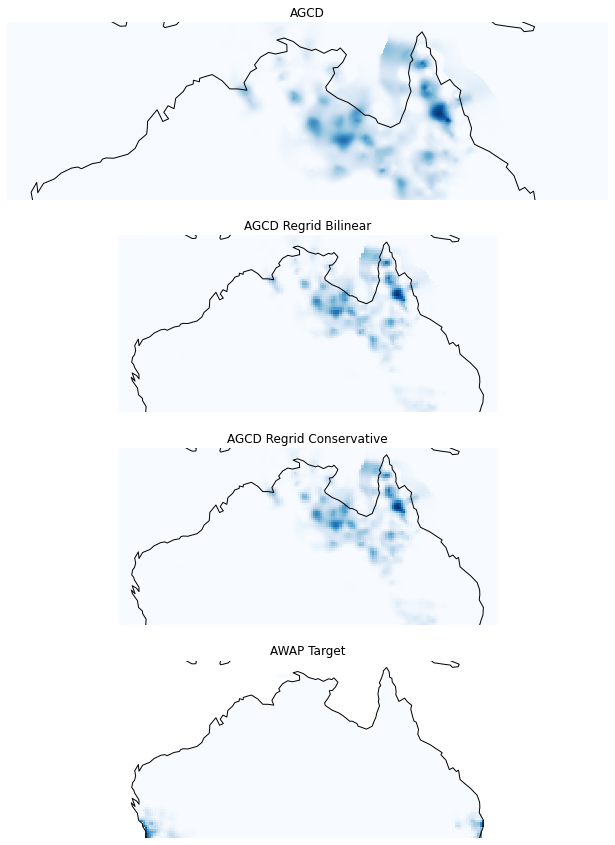

In [79]:
fig = plt.figure(figsize = (15,15))
gs = gridspec.GridSpec(4,1)

ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
test_file.sel(lat = slice(-23,-10), lon = slice(112,156.2))\
            .isel(time = 0).plot(ax = ax1, add_colorbar = False, cmap = 'Blues')
ax1.coastlines(resolution = '110m')
ax1.spines['geo'].set_visible(False)
ax1.set_title('AGCD')

ax2 = fig.add_subplot(gs[1], projection = ccrs.PlateCarree())
regrid_test.isel(time = 0).plot(ax = ax2, add_colorbar = False, cmap = 'Blues')
ax2.coastlines(resolution = '110m')
ax2.spines['geo'].set_visible(False)
ax2.set_title('AGCD Regrid Bilinear')

ax3 = fig.add_subplot(gs[2], projection = ccrs.PlateCarree())
regrid_test_weighted.isel(time = 0).plot(ax = ax3, add_colorbar = False, cmap = 'Blues')
ax3.coastlines(resolution = '110m')
ax3.spines['geo'].set_visible(False)
ax3.set_title('AGCD Regrid Conservative')


ax4 = fig.add_subplot(gs[3], projection = ccrs.PlateCarree())
awap_target.precip.isel(time = 205).plot(ax = ax4, add_colorbar = False, cmap = 'Blues')
ax4.coastlines(resolution = '110m')
ax4.spines['geo'].set_visible(False)
ax4.set_title('AWAP Target');

# Looping through all datasets

All of the files in this directory need to be regridded using the above wieghted method

In [80]:
awap_target

<xarray.Dataset>
Dimensions:  (lon: 173, lat: 81, time: 39082)
Coordinates:
  * lon      (lon) float64 112.0 112.2 112.5 112.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * time     (time) datetime64[ns] 1911-01-01T09:00:00 ... 2017-12-31T09:00:00
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.2 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Fri Dec 07 18:54:17 2018: cdo ifthen grid_0.25.nc precip_ca...
    CDO:          Climate Data Operators version 1.6.2 (http://code.zmaw.de/p...

In [81]:
LAT1 = awap_target.lat.values[0]
LAT2 = awap_target.lat.values[-1]
LON1 = awap_target.lon.values[0]
LON2 = awap_target.lon.values[-1]
print(LAT1, LAT2,LON1, LON2)

-30.0 -10.0 112.0 155.0


In [82]:
test_file = xr.open_dataset(f'{UNREGRID_DIR}/agcd_v1_precip_calib_r005_daily_2003.nc')
test_file = test_file.isel(nv = 0).squeeze().precip
test_file

<xarray.DataArray 'precip' (time: 365, lat: 691, lon: 886)>
[223462490 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-12-31T09:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:                  time: sum
    units:                         mm
    analysis_version_number:       3.01
    long_name:                     Daily precipitation
    number_of_stations_reporting:  6786
    standard_name:                 lwe_thickness_of_precipitation_amount
    frequency:                     daily
    length_scale_for_analysis:     80.0
    grid_mapping:                  crs
    coverage_content_type:         physicalMeasurement
    valid_range:                   [     0. 100000.]

In [83]:
test_file

<xarray.DataArray 'precip' (time: 365, lat: 691, lon: 886)>
[223462490 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-12-31T09:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:                  time: sum
    units:                         mm
    analysis_version_number:       3.01
    long_name:                     Daily precipitation
    number_of_stations_reporting:  6786
    standard_name:                 lwe_thickness_of_precipitation_amount
    frequency:                     daily
    length_scale_for_analysis:     80.0
    grid_mapping:                  crs
    coverage_content_type:         physicalMeasurement
    valid_range:                   [     0. 100000.]

In [84]:
weights = climtas.regrid.cdo_generate_weights(test_file, awap_target, method = 'con')

In [85]:
agcd_regridder_weighted = climtas.regrid.Regridder(weights = weights)
agcd_regridder_weighted

In [86]:
ungrided_file_dir = np.array(os.listdir(UNREGRID_DIR))

In [87]:
ungrided_file_dir[:5]

array(['agcd_v1_precip_calib_r005_daily_2003.nc',
       'agcd_v1_precip_calib_r005_daily_1948.nc',
       'agcd_v1_precip_calib_r005_daily_1940.nc',
       'agcd_v1_precip_calib_r005_daily_1911.nc',
       'agcd_v1_precip_calib_r005_daily_1921.nc'], dtype='<U39')

In [88]:
test_file = xr.open_dataset(f'{UNREGRID_DIR}/{ungrided_file_dir[0]}')\
    .sel(lat = slice(LAT1, LAT2), lon = slice(LON1, LON2))

In [89]:
weights = climtas.regrid.cdo_generate_weights(test_file, awap_target, method = 'con')

In [91]:
climtas.regrid.compute_weights_matrix(weights)

dask.array<from-value, shape=(345261, 14013), dtype=float64, chunksize=(345261, 14013), chunktype=numpy.ndarray>

In [92]:
agcd_regridder_weighted = climtas.regrid.Regridder(weights = weights)
agcd_regridder_weighted

In [93]:
num_files = len(ungrided_file_dir)
num_files

121

In [94]:
SAVE_DIR = '/g/data/w40/ab2313/mjo_and_rainfall_trend/agcd_yearly_regrid'

In [95]:
required_years = np.arange(1970, 2024)
required_years

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [99]:
print(f'All files saved in directory: {SAVE_DIR}')
print('Files saved:\n---------')
print('awap_{}.nc')
for year in required_years:

    agcd_single_year = xr.open_dataset(f'{UNREGRID_DIR}/agcd_v1_precip_calib_r005_daily_{year}.nc')
    agcd_single_year = agcd_single_year.sel(lat = slice(LAT1, LAT2), lon = slice(LON1, LON2))
    agcd_single_year = agcd_single_year.where(
        agcd_single_year.time.dt.month.isin([10,12,12,1,2,3]), drop = True)
    
    agcd_single_year = agcd_single_year.isel(nv = 0).squeeze().precip
    
    agcd_single_year_regrid = agcd_regridder_weighted.regrid(agcd_single_year)
    
    agcd_single_year_regrid.to_netcdf(f'{SAVE_DIR}/awap_{year}.nc')
    print(f'{year}, ', end = '')

All files saved in directory: /g/data/w40/ab2313/mjo_and_rainfall_trend/agcd_yearly_regrid
Files saved:
---------
awap_{}.nc
1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 

FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/zv2/agcd/v1/precip/calib/r005/01day/agcd_v1_precip_calib_r005_daily_2021.nc'

# Merging All Files in Savedir

In [100]:
awap_full = xr.open_mfdataset(os.path.join(SAVE_DIR, '*.nc'))

In [101]:
np.unique(awap_full.time.dt.year.values)

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [102]:
awap_full.isel(time = 50)

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 173)
Coordinates:
    time     datetime64[ns] 1970-02-20T09:00:00
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 112.0 112.3 112.5 112.8 ... 154.3 154.5 154.7 155.0
Data variables:
    precip   (lat, lon) float64 dask.array<chunksize=(81, 173), meta=np.ndarray>

In [103]:
awap_target

<xarray.Dataset>
Dimensions:  (lon: 173, lat: 81, time: 39082)
Coordinates:
  * lon      (lon) float64 112.0 112.2 112.5 112.8 ... 154.2 154.5 154.8 155.0
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * time     (time) datetime64[ns] 1911-01-01T09:00:00 ... 2017-12-31T09:00:00
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.2 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    history:      Fri Dec 07 18:54:17 2018: cdo ifthen grid_0.25.nc precip_ca...
    CDO:          Climate Data Operators version 1.6.2 (http://code.zmaw.de/p...

In [104]:
np.testing.assert_almost_equal(np.array(awap_target.lat.values), np.array(awap_full.lat.values))

In [105]:
awap_target.lat.values

array([-30.  , -29.75, -29.5 , -29.25, -29.  , -28.75, -28.5 , -28.25,
       -28.  , -27.75, -27.5 , -27.25, -27.  , -26.75, -26.5 , -26.25,
       -26.  , -25.75, -25.5 , -25.25, -25.  , -24.75, -24.5 , -24.25,
       -24.  , -23.75, -23.5 , -23.25, -23.  , -22.75, -22.5 , -22.25,
       -22.  , -21.75, -21.5 , -21.25, -21.  , -20.75, -20.5 , -20.25,
       -20.  , -19.75, -19.5 , -19.25, -19.  , -18.75, -18.5 , -18.25,
       -18.  , -17.75, -17.5 , -17.25, -17.  , -16.75, -16.5 , -16.25,
       -16.  , -15.75, -15.5 , -15.25, -15.  , -14.75, -14.5 , -14.25,
       -14.  , -13.75, -13.5 , -13.25, -13.  , -12.75, -12.5 , -12.25,
       -12.  , -11.75, -11.5 , -11.25, -11.  , -10.75, -10.5 , -10.25,
       -10.  ])

In [106]:
awap_full.lat.values

array([-30.  , -29.75, -29.5 , -29.25, -29.  , -28.75, -28.5 , -28.25,
       -28.  , -27.75, -27.5 , -27.25, -27.  , -26.75, -26.5 , -26.25,
       -26.  , -25.75, -25.5 , -25.25, -25.  , -24.75, -24.5 , -24.25,
       -24.  , -23.75, -23.5 , -23.25, -23.  , -22.75, -22.5 , -22.25,
       -22.  , -21.75, -21.5 , -21.25, -21.  , -20.75, -20.5 , -20.25,
       -20.  , -19.75, -19.5 , -19.25, -19.  , -18.75, -18.5 , -18.25,
       -18.  , -17.75, -17.5 , -17.25, -17.  , -16.75, -16.5 , -16.25,
       -16.  , -15.75, -15.5 , -15.25, -15.  , -14.75, -14.5 , -14.25,
       -14.  , -13.75, -13.5 , -13.25, -13.  , -12.75, -12.5 , -12.25,
       -12.  , -11.75, -11.5 , -11.25, -11.  , -10.75, -10.5 , -10.25,
       -10.  ])

In [107]:
awap_full['lat'] = awap_target.lat.values

In [108]:
awap_full['lon'] = awap_target.lon.values

In [109]:
awap_target = awap_target.load()

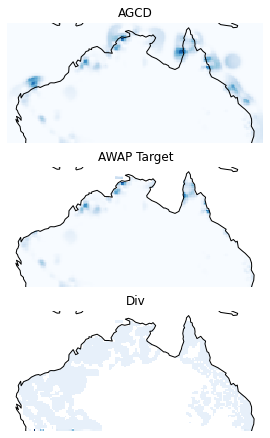

In [127]:
fig = plt.figure(figsize = (15,7.5))
gs = gridspec.GridSpec(3,1)

ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
regrid_plot_data = awap_full.isel(time = 2500)
regrid_plot_data.precip.plot(ax = ax1, add_colorbar = False, cmap = 'Blues')
ax1.coastlines(resolution = '110m')
ax1.spines['geo'].set_visible(False)
ax1.set_title('AGCD')

ax2 = fig.add_subplot(gs[1], projection = ccrs.PlateCarree())

plot_time = regrid_plot_data.time.values
awap_target.sel(time = plot_time- pd.to_timedelta('9H'), method='nearest').precip\
            .plot(ax = ax2, add_colorbar = False, cmap = 'Blues')
ax2.coastlines(resolution = '110m')
ax2.spines['geo'].set_visible(False)
ax2.set_title('AWAP Target');


ax3 = fig.add_subplot(gs[2], projection = ccrs.PlateCarree())

plot_time = regrid_plot_data.time.values
div_data = (awap_target.sel(time = plot_time- pd.to_timedelta('9H'), method='nearest').precip/\
            regrid_plot_data.precip)
div_data.plot(ax = ax3, add_colorbar = False, cmap = 'Blues')
ax3.coastlines(resolution = '110m')
ax3.spines['geo'].set_visible(False)
ax3.set_title('Div');

These plots are the same, however everythign that is ocer the ocean has been removed.

In [128]:
awap_full

<xarray.Dataset>
Dimensions:  (time: 7703, lat: 81, lon: 173)
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T09:00:00 ... 2020-03-31T09:00:00
  * lat      (lat) float64 -30.0 -29.75 -29.5 -29.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 112.0 112.2 112.5 112.8 ... 154.2 154.5 154.8 155.0
Data variables:
    precip   (time, lat, lon) float64 dask.array<chunksize=(152, 81, 173), meta=np.ndarray>

In [129]:
awap_full.encoding

{}

In [130]:
awap_full.attrs = {'History':'AWAP regirdded from AGCD with conservative regridding.',
                'Date':'25/6/2021',
                'Domain': 'Only includes Austral wet season dates and northern Austrlia spacial domain.'}

In [133]:
awap_full.to_netcdf(os.path.join(AWAP_DIR, 'awap_full.nc'))